# Loading the Dataset

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, classification_report, roc_auc_score

In [4]:
df = pd.read_csv('fraud_detection.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Data Cleaning

In [46]:
df.shape

(6362620, 16)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [47]:
df.isna().sum()

step                      0
amount                    0
oldbalanceOrg             0
oldbalanceDest            0
isFraud                   0
CASH_IN                   0
CASH_OUT                  0
DEBIT                     0
PAYMENT                   0
TRANSFER                  0
dest_diff                 0
orig_diff                 0
dest_diff_abs             0
orig_diff_abs             0
orig_balance_unchanged    0
dest_balance_zero         0
dtype: int64

In [8]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [9]:
df = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

# Outlier Analysis

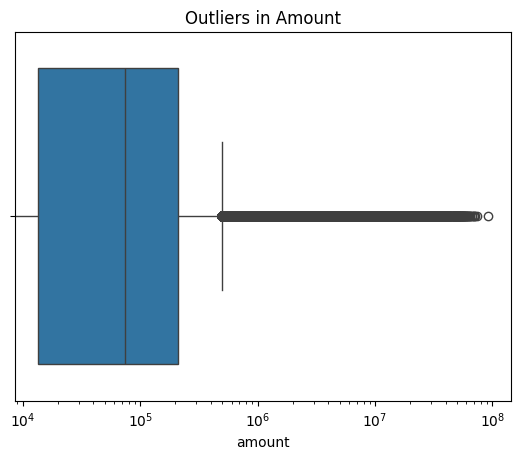

In [10]:
sns.boxplot(x = 'amount', data = df)
plt.xscale('log')
plt.title('Outliers in Amount')
plt.show()

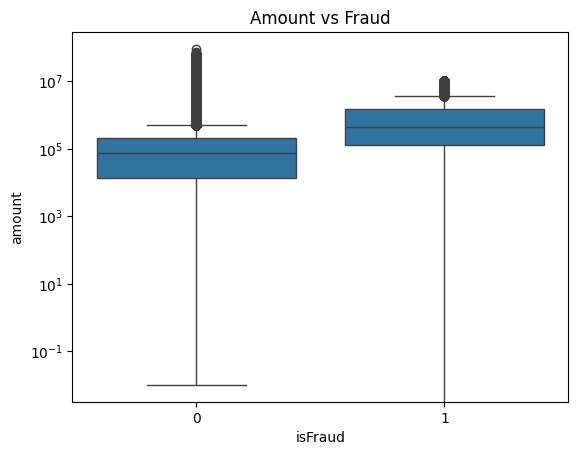

In [11]:
sns.boxplot(x = 'isFraud', y = 'amount', data=df)
plt.yscale('log') 
plt.title('Amount vs Fraud')
plt.show()

# Data Visualization

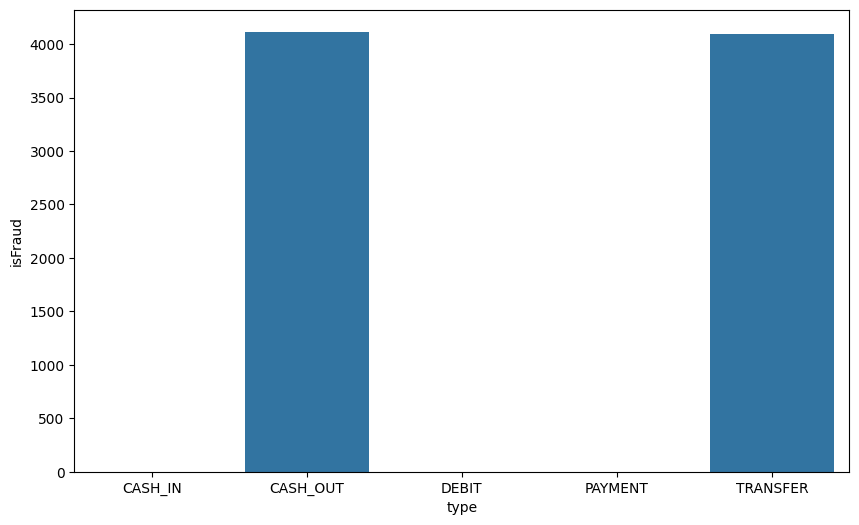

In [12]:
fraud_rate = df.groupby('type')['isFraud'].sum().reset_index()
plt.figure(figsize = (10,6))
sns.barplot(x = 'type', y = 'isFraud', data = fraud_rate)
plt.show()

Multi-Collinearity

In [13]:
df = df.join(pd.get_dummies(df['type'])).drop(['type'], axis = 1)
df.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.004077,-0.012918,0.002869,0.004926,0.006925
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,-0.009621,-0.004376,-0.023379,-0.197444,0.365896
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.506761,-0.200899,-0.021450,-0.189486,-0.081593
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.527373,-0.210977,-0.021872,-0.193915,-0.087355
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,0.076105,0.086028,0.009347,-0.231455,0.130476
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,0.034988,0.093476,0.006346,-0.238315,0.191701
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,-0.019089,0.011256,-0.002911,-0.025697,0.053869
CASH_IN,0.004077,-0.009621,0.506761,0.527373,0.076105,0.034988,-0.019089,1.000000,-0.391047,-0.042987,-0.379522,-0.160535
CASH_OUT,-0.012918,-0.004376,-0.200899,-0.210977,0.086028,0.093476,0.011256,-0.391047,1.000000,-0.059625,-0.526422,-0.222672
DEBIT,0.002869,-0.023379,-0.021450,-0.021872,0.009347,0.006346,-0.002911,-0.042987,-0.059625,1.000000,-0.057868,-0.024478


<Axes: >

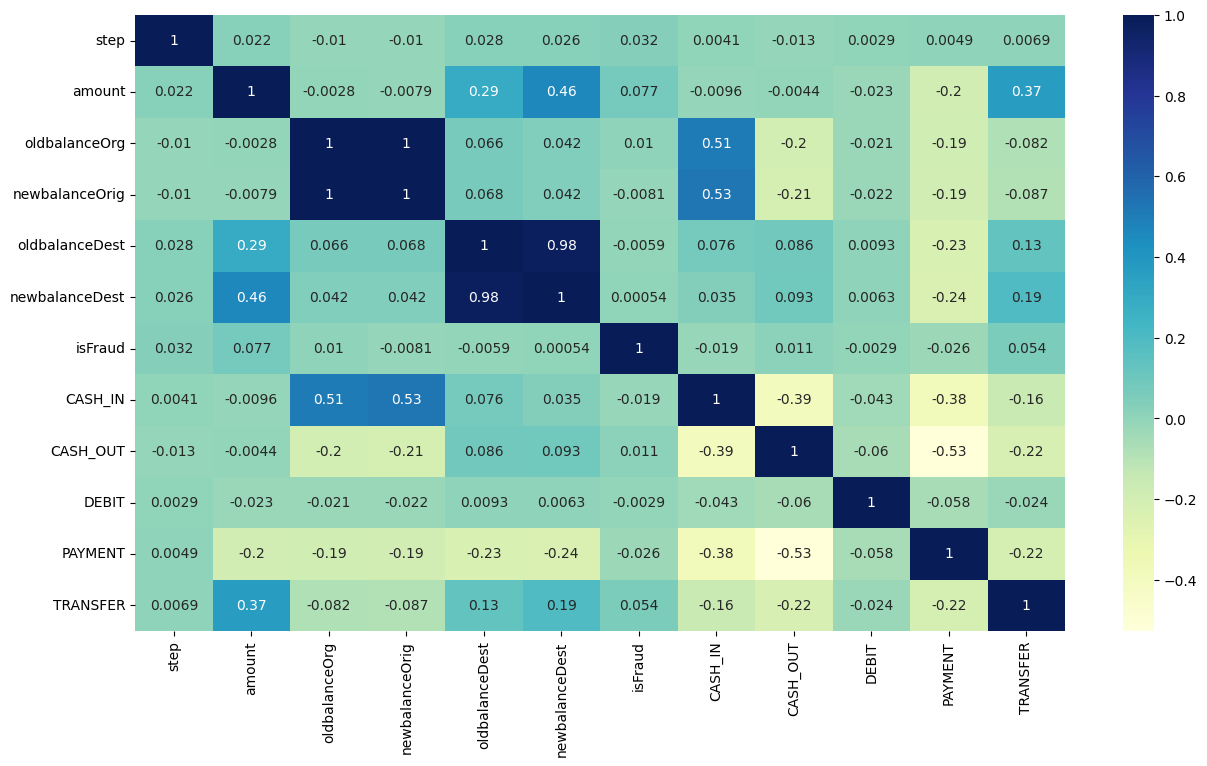

In [14]:
plt.figure(figsize = (15,8))
sns.heatmap(df.corr(), annot = True, cmap = "YlGnBu")

# Feature Engineering

Old - New Balance Maths Features 

In [15]:
df['dest_diff'] = df['newbalanceDest'] - (df['oldbalanceDest'] - df['amount'])
df['orig_diff'] = df['newbalanceOrig'] - (df['oldbalanceOrg'] + df['amount'])
df['dest_diff_abs'] = df['dest_diff'].abs()
df['orig_diff_abs'] = df['orig_diff'].abs()

Logical Flags

In [16]:
df['orig_balance_unchanged'] = ((df['oldbalanceOrg'] == df['newbalanceOrig']) & (df['amount'] > 0)).astype(int)
df['dest_balance_zero'] = ((df['newbalanceDest'] == 0) & (df['amount'] > 0)).astype(int)

Feature Selection

In [17]:
df = df.drop(columns=['newbalanceOrig', 'newbalanceDest'])  # if highly correlated

In [27]:
df.head()

,step,amount,oldbalanceOrg,oldbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,dest_diff,orig_diff,dest_diff_abs,orig_diff_abs,orig_balance_unchanged,dest_balance_zero
0,1,9839.64,170136.0,0.0,0,False,False,False,True,False,9839.64,-19679.28,9839.64,19679.28,0,1
1,1,1864.28,21249.0,0.0,0,False,False,False,True,False,1864.28,-3728.56,1864.28,3728.56,0,1
2,1,181.00,181.0,0.0,1,False,False,False,False,True,181.00,-362.00,181.00,362.00,0,1
3,1,181.00,181.0,21182.0,1,False,True,False,False,False,-21001.00,-362.00,21001.00,362.00,0,1
4,1,11668.14,41554.0,0.0,0,False,False,False,True,False,11668.14,-23336.28,11668.14,23336.28,0,1


# Model 1: Logistic Regression

In [18]:
x = df.drop('isFraud',axis=1)
y = df['isFraud']

scaler = StandardScaler()
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=1)

x_train_s = scaler.fit_transform(x_train)

Logistic Regression

In [19]:
reg = LogisticRegression(max_iter=1000,
                         solver='lbfgs',
                         class_weight='balanced')
model_1 = reg.fit(x_train_s, y_train)
model_1

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [20]:
x_test_s = scaler.fit_transform(x_test)

In [21]:
y_pred = model_1.predict(x_test_s)
y_prob = model_1.predict_proba(x_test_s)[:, 1]

Evaluation

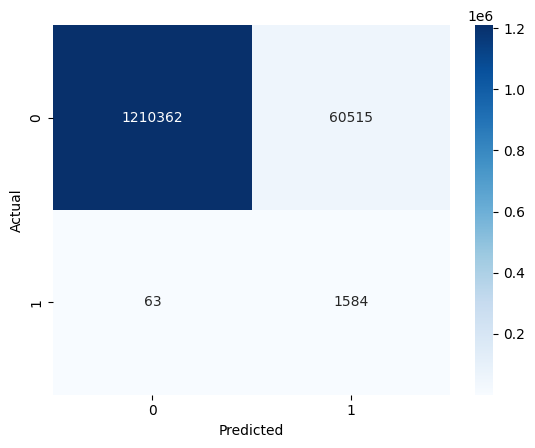

In [22]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [23]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.999948,0.952383,0.975586,1.270877e+06
1,0.025508,0.961749,0.049697,1.647000e+03
accuracy,0.952395,0.952395,0.952395,9.523954e-01
macro avg,0.512728,0.957066,0.512642,1.272524e+06
weighted avg,0.998687,0.952395,0.974388,1.272524e+06


In [24]:
roc_auc_score(y_test, y_prob)

0.9925926849899076

# Feature Importance

Logistic Regression Coefficients

In [35]:
features = list(x.columns)
coefficients = model_1.coef_[0]  

importances_lr = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})

importances_lr = importances_lr.sort_values(by = 'Abs_Coefficient', ascending=False)

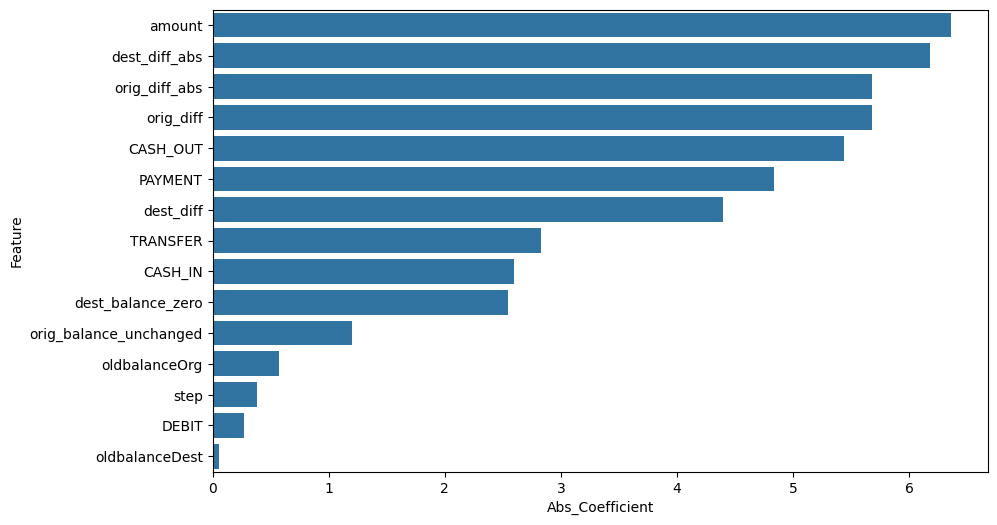

In [37]:
plt.figure(figsize=(10,6))
sns.barplot(x = 'Abs_Coefficient', y = 'Feature', data = importances_lr)
plt.show()

# Prevention Strategies

In [44]:
df_test = df.loc[x_test.index].copy()
df_test['fraud_prob'] = y_prob

def prevention_action(p):
    if p > 0.9:
        return "Block Transaction"
    elif p > 0.7:
        return "Step-up Authentication"
    elif p > 0.4:
        return "Monitor"
    else:
        return "Allow"

df_test['action'] = df_test['fraud_prob'].apply(prevention_action)
df_test['action'].value_counts()

action
Allow                     1180453
Monitor                     65893
Step-up Authentication      17569
Block Transaction            8609
Name: count, dtype: int64

# Effectiveness 

In [45]:
fraud_amount = df_test.loc[y_test == 1, 'amount'].sum()

caught_fraud = df_test.loc[(y_test == 1) & (y_pred == 1),'amount'].sum()

print("Total Fraud Amount:", fraud_amount)
print("Prevented Fraud Amount:", caught_fraud)
print("Prevention Rate:", caught_fraud / fraud_amount)

Total Fraud Amount: 2318059071.12
Prevented Fraud Amount: 2314610064.48
Prevention Rate: 0.998512114431004
